In [2]:
# Make all data ready and save to "combined_financial_data.csv"

import pandas as pd
import yfinance as yf
from fredapi import Fred

# Set date range
start_date = "2019-01-01"
end_date = "2024-12-31"

# Fetch Bitcoin data from Yahoo Finance
btc = yf.download("BTC-USD", start=start_date, end=end_date)
btc = btc[["Close", "Volume"]].rename(columns={"Close": "BTC_Close", "Volume": "BTC_Volume"})

# Fetch S&P 500 data from Yahoo Finance
sp500 = yf.download("^GSPC", start=start_date, end=end_date)
sp500 = sp500[["Close"]].rename(columns={"Close": "SP500_Close"})

# Fetch 10-Year Treasury Rate from FRED
fred = Fred(api_key="9659e8a704223554390daacfd74c6b86")  # Replace with your FRED API key
treasury_rate = fred.get_series("DGS10", start_date, end_date)
treasury_rate = treasury_rate.rename("10Y_Treasury_Rate").to_frame()

# Convert FRED series to DataFrame and reset index
treasury_rate.index = pd.to_datetime(treasury_rate.index)

# Merge datasets
merged_df = sp500.join([btc, treasury_rate], how="left")

# Remove rows where S&P 500 closing price is missing
merged_df = merged_df.dropna(subset=["SP500_Close"])

# Save the cleaned dataset
merged_df.to_csv("combined_financial_data.csv")

# Display the first few rows
print(merged_df.head())


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
            SP500_Close    BTC_Close    BTC_Volume  10Y_Treasury_Rate
Date                                                                 
2019-01-02  2510.030029  3943.409424  5.244857e+09               2.66
2019-01-03  2447.889893  3836.741211  4.530215e+09               2.56
2019-01-04  2531.939941  3857.717529  4.847965e+09               2.67
2019-01-07  2549.689941  4025.248291  5.228626e+09               2.70
2019-01-08  2574.409912  4030.847900  5.306593e+09               2.73


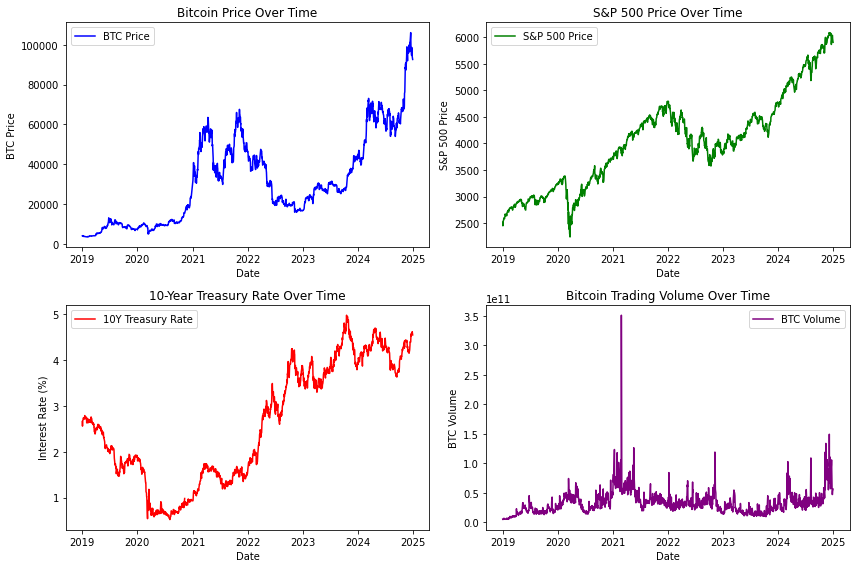

In [4]:
# Plot the data -- BTC closing price, SP 500 closing, 10-year treasury yield, BTC trading volume

import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv("combined_financial_data.csv")

# Convert 'Date' column to datetime format for proper plotting
df['Date'] = pd.to_datetime(df['Date'])

# Set up a 2x2 subplot layout
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Plot BTC price over time
axes[0, 0].plot(df['Date'], df['BTC_Close'], label='BTC Price', color='blue')
axes[0, 0].set_title('Bitcoin Price Over Time')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('BTC Price')
axes[0, 0].legend()

# Plot S&P 500 price over time
axes[0, 1].plot(df['Date'], df['SP500_Close'], label='S&P 500 Price', color='green')
axes[0, 1].set_title('S&P 500 Price Over Time')
axes[0, 1].set_xlabel('Date')
axes[0, 1].set_ylabel('S&P 500 Price')
axes[0, 1].legend()

# Plot interest rate over time
axes[1, 0].plot(df['Date'], df['10Y_Treasury_Rate'], label='10Y Treasury Rate', color='red')
axes[1, 0].set_title('10-Year Treasury Rate Over Time')
axes[1, 0].set_xlabel('Date')
axes[1, 0].set_ylabel('Interest Rate (%)')
axes[1, 0].legend()

# Plot BTC trading volume over time
axes[1, 1].plot(df['Date'], df['BTC_Volume'], label='BTC Volume', color='purple')
axes[1, 1].set_title('Bitcoin Trading Volume Over Time')
axes[1, 1].set_xlabel('Date')
axes[1, 1].set_ylabel('BTC Volume')
axes[1, 1].legend()

# Improve layout and display the plot
plt.tight_layout()
plt.show()


In [5]:
# Preliminary test

import pandas as pd
import statsmodels.api as sm

# Load dataset from Excel file
file_path = "combined_financial_data.csv"
df = pd.read_csv(file_path, parse_dates=["Date"], index_col="Date")

# Ensure required columns exist
df = df.dropna(subset=["BTC_Close", "SP500_Close", "10Y_Treasury_Rate", "BTC_Volume"])

# Add month column
df["Month"] = df.index.month

# Function to run regression and extract coefficients & R-squared
def run_regression(dependent, independent_vars):
    X = df[independent_vars]
    X = sm.add_constant(X)  # Add constant term
    y = df[dependent]
    model = sm.OLS(y, X).fit()
    return model.params, model.rsquared

# Run regressions and store results
regression_results = {
    "BTC on SP500": run_regression("BTC_Close", ["SP500_Close"]),
    "BTC on SP500, Interest": run_regression("BTC_Close", ["SP500_Close", "10Y_Treasury_Rate"]),
    "BTC on SP500, Interest, Volume": run_regression("BTC_Close", ["SP500_Close", "10Y_Treasury_Rate", "BTC_Volume"]),
    "BTC on SP500, Interest, Volume, Month": run_regression("BTC_Close", ["SP500_Close", "10Y_Treasury_Rate", "BTC_Volume", "Month"]),
}

# Convert results to DataFrame for display
results_df = pd.DataFrame.from_dict(regression_results, orient="index", columns=["Coefficients", "R-squared"])

# Display the first few rows
print(df.head())

# Display results
print(results_df)

            SP500_Close    BTC_Close    BTC_Volume  10Y_Treasury_Rate  Month
Date                                                                        
2019-01-02  2510.030029  3943.409424  5.244857e+09               2.66      1
2019-01-03  2447.889893  3836.741211  4.530215e+09               2.56      1
2019-01-04  2531.939941  3857.717529  4.847965e+09               2.67      1
2019-01-07  2549.689941  4025.248291  5.228626e+09               2.70      1
2019-01-08  2574.409912  4030.847900  5.306593e+09               2.73      1
                                                                            Coefficients  \
BTC on SP500                           const         -62418.372755
SP500_Close       ...   
BTC on SP500, Interest                 const               -66082.472244
SP500_Close ...   
BTC on SP500, Interest, Volume         const               -6.585011e+04
SP500_Close ...   
BTC on SP500, Interest, Volume, Month  const               -6.456082e+04
SP500_Close ...   



In [9]:
# Explore Univariate regressions

# Re-load the dataset after execution state reset
import pandas as pd
import statsmodels.api as sm
from IPython.core.display import display, HTML

# Load the dataset
df = pd.read_csv("combined_financial_data.csv")

# Convert 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Drop rows with missing values
df_cleaned = df.dropna()

# Extract the month from the Date column and assign an index for time
df_cleaned["Month_Index"] = range(1, len(df_cleaned) + 1)

# Define independent variables and dependent variable
X_vars = {
    "S&P 500": df_cleaned["SP500_Close"],
    "10Y Treasury Rate": df_cleaned["10Y_Treasury_Rate"],
    "BTC Volume": df_cleaned["BTC_Volume"],
    "Time (Months)": df_cleaned["Month_Index"]
}

Y_var = df_cleaned["BTC_Close"]  # Dependent variable: BTC Price

# Perform linear regressions and store results including t-statistics
regression_results = {}

for name, X in X_vars.items():
    X = sm.add_constant(X)  # Add intercept term
    model = sm.OLS(Y_var, X).fit()  # Fit the model
    regression_results[name] = {
        "Coefficient (slope)": model.params[1],
        "Intercept": model.params[0],
        "R-squared": model.rsquared,
        "t-statistic": model.tvalues[1]
    }

# Display all regression results together in a formatted output
html_output = "<h3 style='color:blue;'>Regression Results for Bitcoin Price:</h3>"
for name, results in regression_results.items():
    html_output += f"<b>{name}:</b><br>"
    html_output += f"Coefficient (slope): {results['Coefficient (slope)']:.4f}<br>"
    html_output += f"Intercept: {results['Intercept']:.4f}<br>"
    html_output += f"t-statistic: {results['t-statistic']:.4f}<br>"
    html_output += f"R-squared: {results['R-squared']:.4f}<br><br>"

display(HTML(html_output))



<ipython-input-9-26d196309fef>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned["Month_Index"] = range(1, len(df_cleaned) + 1)


In [10]:
# All variables together

import pandas as pd
import statsmodels.api as sm

# Load the dataset
file_path = "combined_financial_data.csv"  # Ensure the file is in the same directory or provide full path
df = pd.read_csv(file_path)

# Convert 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Drop rows with missing values
df_cleaned = df.dropna()

# Extract the month from the Date column and assign an index for time
df_cleaned["Month_Index"] = range(1, len(df_cleaned) + 1)

# Define independent variables and dependent variable
X_all = df_cleaned[["SP500_Close", "10Y_Treasury_Rate", "BTC_Volume", "Month_Index"]]
X_all = sm.add_constant(X_all)  # Add intercept term
Y_btc = df_cleaned["BTC_Close"]

# Run multiple regression
model_all = sm.OLS(Y_btc, X_all).fit()

# Print regression summary
print(model_all.summary())


                            OLS Regression Results                            
Dep. Variable:              BTC_Close   R-squared:                       0.906
Model:                            OLS   Adj. R-squared:                  0.906
Method:                 Least Squares   F-statistic:                     3608.
Date:                Wed, 12 Feb 2025   Prob (F-statistic):               0.00
Time:                        21:10:06   Log-Likelihood:                -15330.
No. Observations:                1498   AIC:                         3.067e+04
Df Residuals:                    1493   BIC:                         3.070e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -8.866e+04   1477.06

<ipython-input-10-532c5153fa5f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned["Month_Index"] = range(1, len(df_cleaned) + 1)


In [12]:
# Create the data having "Month" variable

import pandas as pd
import statsmodels.api as sm

# Load dataset from CSV file
file_path = "combined_financial_data.csv"
df = pd.read_csv(file_path, parse_dates=["Date"], index_col="Date")

# Ensure required columns exist and drop rows with missing values
df = df.dropna(subset=["BTC_Close", "SP500_Close", "10Y_Treasury_Rate", "BTC_Volume"])

# Add month column
df["Month"] = df.index.month

# Save the updated dataset including the Month column
df.to_csv("combined_financial_data_with_month.csv")

In [16]:
# ML regression 

import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Load dataset from CSV file
file_path = "combined_financial_data_with_month.csv"
threedata = pd.read_csv(file_path)

# Drop rows with missing values (NaN)
threedata = threedata.dropna()

# Ensure correct column names based on dataset
column_mapping = {
    'SP500_Close': 'Close_sp',
    '10Y_Treasury_Rate': 'Close_int',
    'BTC_Volume': 'Volume',
    'BTC_Close': 'Close_btc'
}
threedata = threedata.rename(columns=column_mapping)

# Prepare independent variables (SP500, Interest, Volume, Month) and dependent variable (BTC_Close)
X = threedata[['Close_sp', 'Close_int', 'Volume', 'Month']]  # Independent variables
y = threedata['Close_btc']   # Dependent variable (Bitcoin Close)

# Split the data into training (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Add constant for statsmodels regression
X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)

# Fit the regression model using statsmodels
model_sm = sm.OLS(y_train, X_train_sm).fit()

# Predict on the test set
y_test_pred = model_sm.predict(X_test_sm)

# Extract coefficients and t-statistics
results_df = pd.DataFrame({
    "Variable": model_sm.params.index,
    "Coefficient": model_sm.params.values,
    "t-Statistic": model_sm.tvalues.values
})

# Adding overall performance metrics
performance_df = pd.DataFrame({
    "Metric": ["R-squared (Training)", "MSE (Test)"],
    "Value": [model_sm.rsquared, mean_squared_error(y_test, y_test_pred)]
})

# Combine results
final_results = pd.concat([performance_df, results_df.rename(columns={"Variable": "Metric"})], ignore_index=True)

# Display results
print(final_results)


                 Metric         Value   Coefficient  t-Statistic
0  R-squared (Training)  8.852291e-01           NaN          NaN
1            MSE (Test)  5.016302e+07           NaN          NaN
2                 const           NaN -6.421940e+04   -59.300577
3              Close_sp           NaN  2.426055e+01    67.910848
4             Close_int           NaN -2.129082e+03    -9.513754
5                Volume           NaN  1.911501e-07    16.190788
6                 Month           NaN -4.275963e+02    -6.571916


Mean Squared Error: 61815714.7215


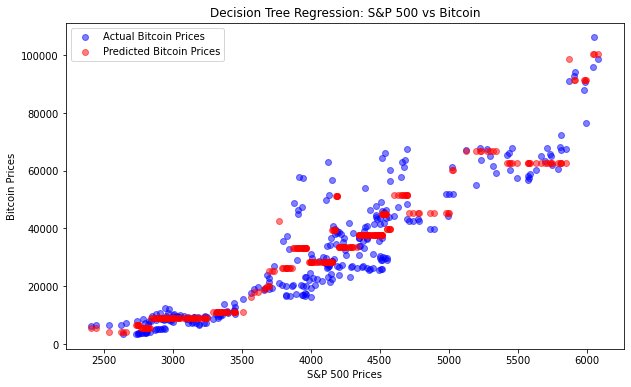

In [17]:
# Decision tree approach

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Load your dataset (Replace with actual paths or data source)
# Assume df contains 'SP500' and 'Bitcoin' price columns
df = pd.read_csv("combined_financial_data_with_month.csv")

# Drop missing values
df = df.dropna()

# Define features (S&P 500) and target (Bitcoin)
X = df[['SP500_Close']].values  # Independent variable (S&P 500 Prices)
y = df['BTC_Close'].values  # Dependent variable (Bitcoin Prices)

# Split the data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize Decision Tree Regressor (splitting to minimize variance)
tree_model = DecisionTreeRegressor(criterion='squared_error', max_depth=5, random_state=42)

# Train the model
tree_model.fit(X_train, y_train)

# Make predictions
y_pred = tree_model.predict(X_test)

# Evaluate model performance
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.4f}")

# Plot the decision tree predictions vs actual Bitcoin prices
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test, label="Actual Bitcoin Prices", color="blue", alpha=0.5)
plt.scatter(X_test, y_pred, label="Predicted Bitcoin Prices", color="red", alpha=0.5)
plt.xlabel("S&P 500 Prices")
plt.ylabel("Bitcoin Prices")
plt.title("Decision Tree Regression: S&P 500 vs Bitcoin")
plt.legend()
plt.show()


In [18]:
# Decision tree evaluation -R2

from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2:.4f}")


R² Score: 0.8696


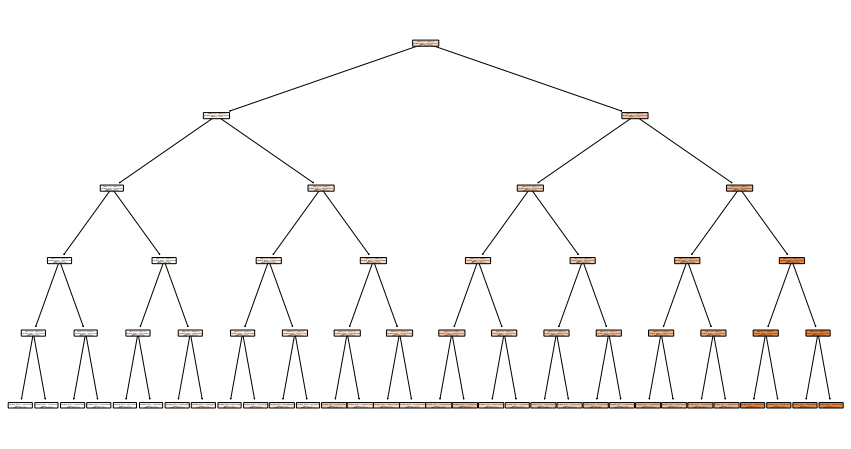

In [19]:
# the tree

from sklearn import tree
plt.figure(figsize=(15,8))
tree.plot_tree(tree_model, filled=True, feature_names=['S&P 500'], rounded=True)
plt.show()


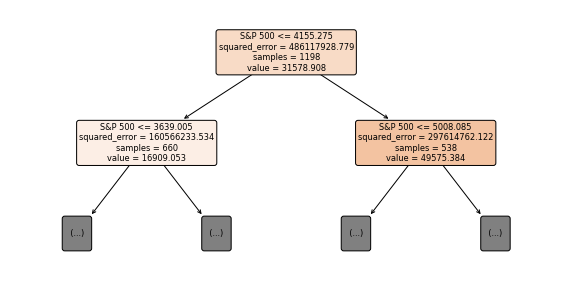

In [31]:
# upper nodes of the tree

import matplotlib.pyplot as plt
from sklearn import tree

# Display only the top 2 levels (change max_depth as needed)
plt.figure(figsize=(10, 5))
tree.plot_tree(tree_model, filled=True, feature_names=['S&P 500'], rounded=True, max_depth=1)
plt.show()

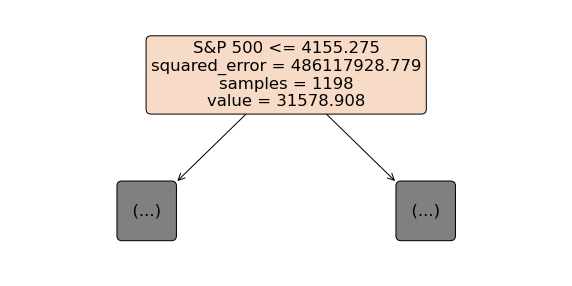

In [32]:
# top node

import matplotlib.pyplot as plt
from sklearn import tree

# Display only the top 2 levels (change max_depth as needed)
plt.figure(figsize=(10, 5))
tree.plot_tree(tree_model, filled=True, feature_names=['S&P 500'], rounded=True, max_depth=0)
plt.show()

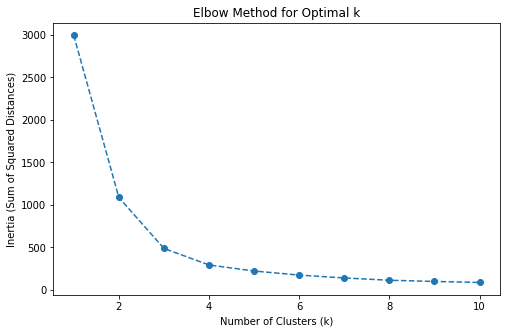

In [1]:
# K-Mean Clustering: Elbow test to pick optimal K

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Load dataset (Replace with actual dataset)
df = pd.read_csv("combined_financial_data_with_month.csv")  # Ensure it has 'SP500' and 'Bitcoin' columns
df = df.dropna()  # Drop missing values if any

# Extract features for clustering
X = df[['SP500_Close', 'BTC_Close']].values  # Use both S&P 500 and Bitcoin prices

# Standardize features (important for K-Means)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# Try different values of k
inertia = []  # Stores sum of squared distances for each k
K_range = range(1, 11)  # Check k from 1 to 10

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)  # Inertia measures clustering quality

# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o', linestyle='--')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia (Sum of Squared Distances)")
plt.title("Elbow Method for Optimal k")
plt.show()


In [2]:
# Silhouette score

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# Load dataset
file_path = "combined_financial_data_with_month.csv"  # Update with correct path
df = pd.read_csv(file_path)

# Drop missing values
df = df.dropna()

# Extract features for clustering
X = df[['SP500_Close', 'BTC_Close']].values

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply K-Means Clustering with k=3
k = 3
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(X_scaled)

# Compute Silhouette Score
silhouette_avg = silhouette_score(X_scaled, df['Cluster'])
print(f"Silhouette Score for k={k}: {silhouette_avg}")

Silhouette Score for k=3: 0.573630469498814



Cluster Centers (Original Scale):
[[ 5386.85651093 67589.26806448]
 [ 4233.6038855  34418.29728724]
 [ 3078.02003476  9359.23299725]]


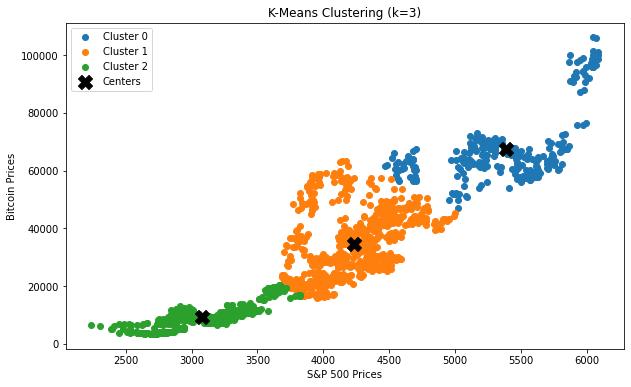

In [39]:
# K Mean BTC and SP

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# === 1️⃣ Load Dataset ===
df = pd.read_csv("combined_financial_data_with_month.csv")  # Ensure it contains 'SP500' and 'Bitcoin' columns
df = df.dropna()  # Remove missing values

# Extract features for clustering
X = df[['SP500_Close', 'BTC_Close']].values  # Use S&P 500 and Bitcoin prices

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === 2️⃣ Apply K-Means Clustering (Set k Manually) ===
k = 3  # Manually set number of clusters
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(X_scaled)  # Assign clusters to data

# Get cluster centers (convert back to original scale)
centers = scaler.inverse_transform(kmeans.cluster_centers_)
print(f"\nCluster Centers (Original Scale):\n{centers}")

# === 3️⃣ Visualizing the Clusters ===
plt.figure(figsize=(10, 6))

# Scatter plot of clusters
for cluster in range(k):
    clustered_data = df[df['Cluster'] == cluster]
    plt.scatter(clustered_data['SP500_Close'], clustered_data['BTC_Close'], label=f'Cluster {cluster}')

# Plot cluster centers
plt.scatter(centers[:, 0], centers[:, 1], color='black', marker='X', s=200, label='Centers')

plt.xlabel("S&P 500 Prices")
plt.ylabel("Bitcoin Prices")
plt.title(f"K-Means Clustering (k={k})")
plt.legend()
plt.show()



Cluster Centers (Original Scale):
[[4.21835498e+00 6.75907229e+04]
 [1.38454039e+00 2.61210646e+04]
 [3.49708561e+00 2.31824837e+04]]


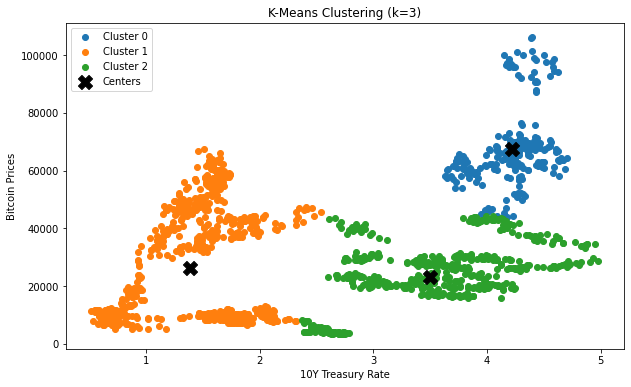

In [40]:
# K Means - BTC and Treasury rate
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# === 1️⃣ Load Dataset ===
df = pd.read_csv("combined_financial_data_with_month.csv")  # Ensure it contains 'SP500' and 'Bitcoin' columns
df = df.dropna()  # Remove missing values

# Extract features for clustering
X = df[['10Y_Treasury_Rate', 'BTC_Close']].values  # Use S&P 500 and Bitcoin prices

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === 2️⃣ Apply K-Means Clustering (Set k Manually) ===
k = 3  # Manually set number of clusters
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(X_scaled)  # Assign clusters to data

# Get cluster centers (convert back to original scale)
centers = scaler.inverse_transform(kmeans.cluster_centers_)
print(f"\nCluster Centers (Original Scale):\n{centers}")

# === 3️⃣ Visualizing the Clusters ===
plt.figure(figsize=(10, 6))

# Scatter plot of clusters
for cluster in range(k):
    clustered_data = df[df['Cluster'] == cluster]
    plt.scatter(clustered_data['10Y_Treasury_Rate'], clustered_data['BTC_Close'], label=f'Cluster {cluster}')

# Plot cluster centers
plt.scatter(centers[:, 0], centers[:, 1], color='black', marker='X', s=200, label='Centers')

plt.xlabel("10Y Treasury Rate")
plt.ylabel("Bitcoin Prices")
plt.title(f"K-Means Clustering (k={k})")
plt.legend()
plt.show()



Cluster Centers (Original Scale):
[[3.56377266e+10 5.14018454e+04]
 [2.51630384e+10 1.60175301e+04]
 [8.13546473e+10 6.19471278e+04]]


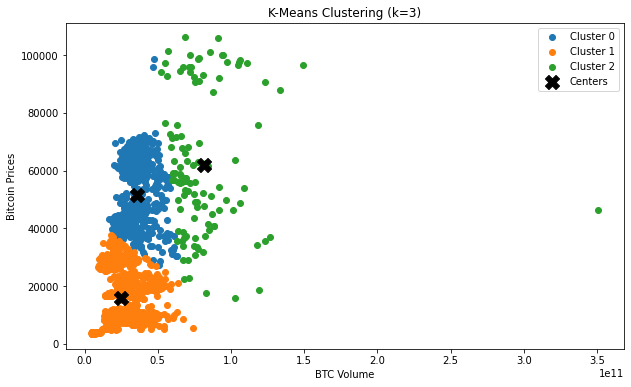

In [41]:
# K means - BTC closing and BTC volume

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# === 1️⃣ Load Dataset ===
df = pd.read_csv("combined_financial_data_with_month.csv")  # Ensure it contains 'SP500' and 'Bitcoin' columns
df = df.dropna()  # Remove missing values

# Extract features for clustering
X = df[['BTC_Volume', 'BTC_Close']].values  # Use S&P 500 and Bitcoin prices

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === 2️⃣ Apply K-Means Clustering (Set k Manually) ===
k = 3  # Manually set number of clusters
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(X_scaled)  # Assign clusters to data

# Get cluster centers (convert back to original scale)
centers = scaler.inverse_transform(kmeans.cluster_centers_)
print(f"\nCluster Centers (Original Scale):\n{centers}")

# === 3️⃣ Visualizing the Clusters ===
plt.figure(figsize=(10, 6))

# Scatter plot of clusters
for cluster in range(k):
    clustered_data = df[df['Cluster'] == cluster]
    plt.scatter(clustered_data['BTC_Volume'], clustered_data['BTC_Close'], label=f'Cluster {cluster}')

# Plot cluster centers
plt.scatter(centers[:, 0], centers[:, 1], color='black', marker='X', s=200, label='Centers')

plt.xlabel("BTC Volume")
plt.ylabel("Bitcoin Prices")
plt.title(f"K-Means Clustering (k={k})")
plt.legend()
plt.show()



Cluster Centers (Original Scale):
[[6.33391914e+04 7.54624277e+00]
 [2.00331473e+04 9.43122677e+00]
 [2.34566311e+04 3.37785016e+00]]


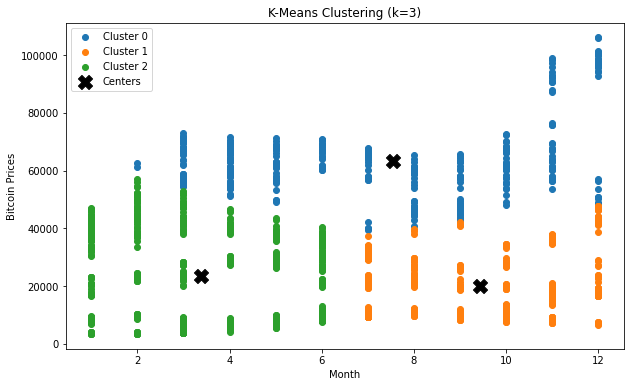

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# Load dataset
file_path = "combined_financial_data_with_month.csv"  # Update with correct path
df = pd.read_csv(file_path)

# Drop missing values
df = df.dropna()

# Extract features for clustering
X = df[['BTC_Close', 'Month']].values  # Use Bitcoin Price and Month

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply K-Means Clustering with k=3
k = 3
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(X_scaled)

# Get cluster centers (convert back to original scale)
centers = scaler.inverse_transform(kmeans.cluster_centers_)
print(f"\nCluster Centers (Original Scale):\n{centers}")

# Visualizing the Clusters
plt.figure(figsize=(10, 6))

# Scatter plot of clusters
for cluster in range(k):
    clustered_data = df[df['Cluster'] == cluster]
    plt.scatter(clustered_data['Month'], clustered_data['BTC_Close'], label=f'Cluster {cluster}')

# Plot cluster centers
plt.scatter(centers[:, 1], centers[:, 0], color='black', marker='X', s=200, label='Centers')

plt.xlabel("Month")
plt.ylabel("Bitcoin Prices")
plt.title(f"K-Means Clustering (k={k})")
plt.legend()
plt.show()
